<a href="https://colab.research.google.com/github/vd4mmind/googleColab/blob/ML_scRNASeq_SK_lab_2020/Day5_of_00_Cell_type_classification_with_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classifying cell types with neural networks

In this notebook, we will build a neural network that classifies cell types in the retinal bipolar dataset for Shekhar et al., 2016. These cells have been manually annotated, and here we will show that a neural network can recapitulate these cell type labels.

## 1. Imports

In [1]:
!pip install scprep

     |████████████████████████████████| 102kB 2.6MB/s 


In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

import scprep

## 2. Loading the retinal bipolar data

We'll use the same retinal bipolar data you saw in preprocessing and visualization.

Alternatively, you may load your own data by replacing the Google Drive file ids with your own file ids.

Note that if you do, you will likely not have annotated celltype labels yet. Replace all references to `metadata['CELLTYPE']` with an entry from `metadata`, or your favorite gene.

In [0]:
scprep.io.download.download_google_drive("1GYqmGgv-QY6mRTJhOCE1sHWszRGMFpnf", "data.pickle.gz")
scprep.io.download.download_google_drive("1q1N1s044FGWzYnQEoYMDJOjdWPm_Uone", "metadata.pickle.gz")

In [0]:
data_raw = pd.read_pickle("data.pickle.gz")
metadata = pd.read_pickle("metadata.pickle.gz")

#### Converting data to `numpy` format

PyTorch expects data to be stored as a NumPy array.

In [5]:
data = scprep.reduce.pca(data_raw, n_components=50, method='dense').to_numpy()
data

array([[ -2.86639095,  16.11995588,   4.36943206, ...,   2.79103816,
         -0.90273699,  -0.77085356],
       [ -0.66863206,  13.21553129,  -4.89263896, ...,  -1.73660224,
         -1.4395917 ,   0.44172934],
       [  0.29665496,   6.85551504,  18.19106802, ...,  -1.78517726,
         -0.96098625,   1.49848892],
       ...,
       [ 39.5113115 ,  -8.20886489, -10.16420664, ...,  -1.20615265,
          0.75203509,  -1.04172818],
       [  3.13934964,  15.10619606,   3.69472746, ...,  -1.91958416,
          0.63636944,   2.35164629],
       [ 42.90597659,  -9.79281524, -13.25214987, ...,  -4.40670807,
         -1.00299879,  -1.09047869]])

For easier classification, we'll scale the data to have mean 0 and standard deviation 1 across all features.

In [6]:
data = data - data.mean(axis=0)
data = data / data.std(axis=0)
data

array([[-0.17060225,  1.43324626,  0.61033181, ...,  1.26143664,
        -0.40926592, -0.34950231],
       [-0.03979573,  1.17501009, -0.6834145 , ..., -0.78487415,
        -0.65265501,  0.20027854],
       [ 0.01765635,  0.60953277,  2.54096811, ..., -0.8068281 ,
        -0.43567387,  0.67940964],
       ...,
       [ 2.35163964, -0.72986086, -1.41975858, ..., -0.54513233,
         0.34094352, -0.47231592],
       [ 0.18684824,  1.34311156,  0.5160876 , ..., -0.86757459,
         0.28850521,  1.06622821],
       [ 2.55368378, -0.87069195, -1.85108924, ..., -1.99165425,
        -0.45472073, -0.49441923]])

In [7]:
labels, cluster_names = pd.factorize(metadata['CELLTYPE'])
labels

array([ 0,  1,  2, ..., 20, 20, 20])

In [8]:
num_classes = len(np.unique(labels))
num_classes

29

#### Splitting the data into training and validation sets

We'll allocate 80\% of our data for training and 20\% for testing. You can also do this with scikit-learn:

```python
from sklearn.model_selection import train_test_split
data_training, data_validation, labels_training, labels_validation = train_test_split(
    data, labels, test_size=0.2)
```

In [9]:
# first let's split our data into training and validation sets
train_test_split = int(.8 * data.shape[0])

data_training = data[:train_test_split, :]
labels_training = labels[:train_test_split]
data_validation = data[train_test_split:, :]
labels_validation = labels[train_test_split:]
data_training.shape, data_validation.shape

((17241, 50), (4311, 50))

## 3. Moving Our Data to PyTorch Tensors 

By moving our data from numpy arrays to PyTorch Tensors, we can take advantage of the variety of tensor operations available. 

In [0]:
train_tensor = torch.from_numpy(data_training)
train_labels = torch.from_numpy(labels_training)

valid_tensor = torch.from_numpy(data_validation)
valid_labels = torch.from_numpy(labels_validation)

Let's go ahead and check that our tensors are the expected sizes. We can do this identically to how we've previously done it with numpy arrays

In [11]:
# check shapes
print("train tensor shape: {}".format(train_tensor.shape))
print("train labels shape: {}".format(train_labels.shape))

print("valid tensor shape: {}".format(valid_tensor.shape))
print("valid labels shape: {}".format(valid_labels.shape))

train tensor shape: torch.Size([17241, 50])
train labels shape: torch.Size([17241])
valid tensor shape: torch.Size([4311, 50])
valid labels shape: torch.Size([4311])


## Exercise 1 - Tensor Operations 1

1. Create a tensor called x of values (1,20) using torch.arange(). Check the PyTorch documentation for [help](https://pytorch.org/docs/master/generated/torch.arange.html)

2. Reshape this tensor to shape (4,5)

2. Add the constant 5 to x and save this tensor as y

3. Power the values of y to 3rd power and save this tensor as z

4. Print the first row of z



In [16]:
# create x using torch.arange()
x = torch.arange(1, 20)
print(x)
# reshape to (4,5)
#x = torch.reshape(x, (4, 5))
x = torch.reshape(x, [4, 5])

# add 5
#y = torch.add(x, 5) 

# power y to the 3rd power
#z = torch.pow(y, 3)
#tyoe(z)
# print the first row of z
#print(

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19])


RuntimeError: ignored

## Exercise 2 - Tensor Operations 2

1. Subset the training tensor by taking the last 5 rows

2. Double the values and print the result.


In [0]:
# Get the last five rows of `train_tensor`
data_last5 = 

# Multiply by two
last5_double = 

# Print the result
last5_double

## 4. Building a one-layer neural network

Now we know how to write simple recipes in PyTorch, we can create a more complex instruction set defining a simple neural network with a single hidden layer.

In [0]:
class layer(nn.Module):
    def __init__(self, input_size, output_size, activation=None):
        super(layer, self).__init__()

        self.weight = nn.Parameter(torch.randn(input_size, output_size).double(), requires_grad=True)
        self.bias = nn.Parameter(torch.randn(output_size).double(), requires_grad=True)
        self.activation = activation

    def forward(self, x):
        output = torch.matmul(x, self.weight) + self.bias
        if self.activation is not None:
            output = self.activation(output)
        return output

Now, we can make two copies of this layer and stack them together to make a simple neural network.

In [18]:
input_size = data_training.shape[1]
num_hidden = 10

layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create a hidden (middle) layer
hidden_layer = layer_1(train_tensor)

# create the output layer used to classify
output = layer_2(hidden_layer)

output

tensor([[2.7147e-03, 3.6601e-05, 4.1569e-08,  ..., 5.1519e-10, 6.2210e-08,
         4.2610e-01],
        [1.0000e-03, 5.9796e-11, 1.7325e-08,  ..., 8.7616e-05, 9.4777e-16,
         1.2794e-21],
        [2.0801e-10, 1.2290e-05, 1.5316e-18,  ..., 4.8447e-10, 3.7581e-26,
         9.9967e-01],
        ...,
        [3.1830e-02, 1.6419e-01, 4.2618e-04,  ..., 4.0461e-03, 1.3591e-05,
         4.4586e-02],
        [1.4052e-03, 3.3243e-16, 3.2331e-15,  ..., 2.0106e-13, 1.5015e-18,
         2.2311e-14],
        [2.0664e-05, 1.4551e-09, 2.7276e-13,  ..., 2.4454e-13, 7.3614e-16,
         9.9997e-01]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Build the loss function

In order to train our neural network, we need to define a loss function which tells us how well (or how poorly) our classifier performed.

Here, we'll use the cross-entropy loss which we discussed in lecture.

In [0]:
def to_one_hot(y_tensor, c_dims):
    """converts a N-dimensional input to a NxC dimnensional one-hot encoding
    """
    y_tensor = torch.LongTensor(y_tensor)
    y_tensor = y_tensor.type(torch.LongTensor).view(-1, 1)
    c_dims = c_dims if c_dims is not None else int(torch.max(y_tensor)) + 1
    y_one_hot = torch.zeros(y_tensor.size()[0], c_dims).scatter_(1, y_tensor, 1)
    y_one_hot = y_one_hot.view(*y_tensor.shape, -1)
    return y_one_hot.squeeze()

In [20]:
# convert our integer class labels to a binary "one-hot" matrix
labels_one_hot = to_one_hot(train_labels, num_classes)
labels_one_hot

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [21]:
# compute cross entropy
loss = labels_one_hot * torch.log(output+ 1e-6) + (1 - labels_one_hot) * torch.log(1 - output + 1e-6)
loss = -1 * loss.sum()
loss

tensor(273311.8808, dtype=torch.float64, grad_fn=<MulBackward0>)

#### Creating a model with PyTorch

Now let's use some PyTorch magic and create a model using `nn.Sequential`, which we can just treat as some fancy list for PyTorch layers. One of the benefits of this is that we can use `model.parameters()` to pull out the list of network parameters to be optimized.

In [22]:
model = nn.Sequential(layer_1, layer_2)
print(model)

Sequential(
  (0): layer(
    (activation): ReLU()
  )
  (1): layer(
    (activation): Softmax(dim=-1)
  )
)


We can now obtain the output of our model by simply calling `model(data)`.

In [23]:
model(train_tensor)

tensor([[2.7147e-03, 3.6601e-05, 4.1569e-08,  ..., 5.1519e-10, 6.2210e-08,
         4.2610e-01],
        [1.0000e-03, 5.9796e-11, 1.7325e-08,  ..., 8.7616e-05, 9.4777e-16,
         1.2794e-21],
        [2.0801e-10, 1.2290e-05, 1.5316e-18,  ..., 4.8447e-10, 3.7581e-26,
         9.9967e-01],
        ...,
        [3.1830e-02, 1.6419e-01, 4.2618e-04,  ..., 4.0461e-03, 1.3591e-05,
         4.4586e-02],
        [1.4052e-03, 3.3243e-16, 3.2331e-15,  ..., 2.0106e-13, 1.5015e-18,
         2.2311e-14],
        [2.0664e-05, 1.4551e-09, 2.7276e-13,  ..., 2.4454e-13, 7.3614e-16,
         9.9997e-01]], dtype=torch.float64, grad_fn=<SoftmaxBackward>)

#### Create the optimizer

To update the model parameters, PyTorch does all of the heavy lifting for us. The optimizer takes the loss value and calculates how we should change the network weights to improve our results.

In [0]:
# now we need an optimizer that we'll give this loss, and it'll take responsibility
# for updating the network to make this score go down
learning_rate = 0.001

optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)


# how many data points do we want to calculate at once?
batch_size = 128

#### Train the network

Let's train the network for 100 _epochs_. An epoch is defined as having optimized our weights over all of our data points exactly once.

In [26]:
# train the network for 100 epochs
step = 0
print_every = 50
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(100):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 1092.302 training accuracy: 0.279 validation accuracy: 0.108 
Step 100 loss: 888.693 training accuracy: 0.281 validation accuracy: 0.300 
Step 150 loss: 698.769 training accuracy: 0.450 validation accuracy: 0.330 
Step 200 loss: 536.286 training accuracy: 0.581 validation accuracy: 0.436 
Step 250 loss: 459.923 training accuracy: 0.609 validation accuracy: 0.499 
Step 300 loss: 320.865 training accuracy: 0.744 validation accuracy: 0.533 
Step 350 loss: 350.261 training accuracy: 0.643 validation accuracy: 0.570 
Step 400 loss: 311.950 training accuracy: 0.648 validation accuracy: 0.592 
Step 450 loss: 264.068 training accuracy: 0.682 validation accuracy: 0.626 
Step 500 loss: 277.971 training accuracy: 0.711 validation accuracy: 0.642 
Step 550 loss: 233.722 training accuracy: 0.729 validation accuracy: 0.657 
Step 600 loss: 186.948 training accuracy: 0.705 validation accuracy: 0.667 
Step 650 loss: 162.777 training accuracy: 0.797 validation accuracy: 0.692 
Step 700 los

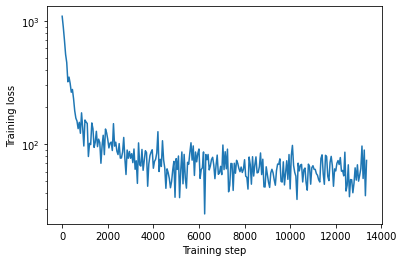

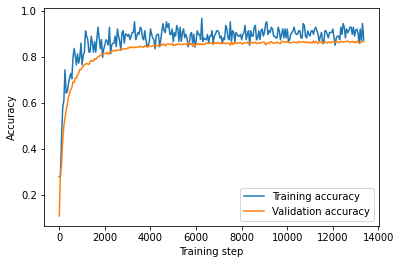

In [27]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did our network do? Is the classification accuracy high? 
2. How many iterations did it take for the training accuracy to stop increasing?
3. How many iterations did it take for the training loss to stop decreasing?
4. How many iterations did it take for the validation accuracy to stop increasing?

## Exercise 3 - network width

Create a network with a wider hidden layer and compare its performance to the network with 10 hidden neurons we just built.

In [29]:
# let's set some hyperparameters
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
# ========
# Build the neural network with a wider hidden layer
num_hidden = 20
# ========

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2)

# create the optimizer
optimizer = optim.SGD(model.parameters(),
                      lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 1852.491 training accuracy: 0.155 validation accuracy: 0.237 
Step 100 loss: 1565.788 training accuracy: 0.203 validation accuracy: 0.335 
Step 150 loss: 1075.396 training accuracy: 0.341 validation accuracy: 0.393 
Step 200 loss: 667.428 training accuracy: 0.566 validation accuracy: 0.523 
Step 250 loss: 408.695 training accuracy: 0.734 validation accuracy: 0.647 
Step 300 loss: 451.378 training accuracy: 0.698 validation accuracy: 0.692 
Step 350 loss: 267.690 training accuracy: 0.806 validation accuracy: 0.705 
Step 400 loss: 217.169 training accuracy: 0.828 validation accuracy: 0.720 
Step 450 loss: 244.754 training accuracy: 0.814 validation accuracy: 0.728 
Step 500 loss: 190.972 training accuracy: 0.812 validation accuracy: 0.736 
Step 550 loss: 203.864 training accuracy: 0.845 validation accuracy: 0.745 
Step 600 loss: 204.547 training accuracy: 0.822 validation accuracy: 0.742 
Step 650 loss: 194.059 training accuracy: 0.852 validation accuracy: 0.765 
Step 700 l

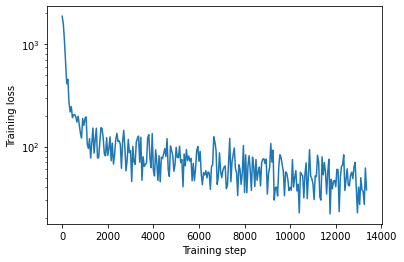

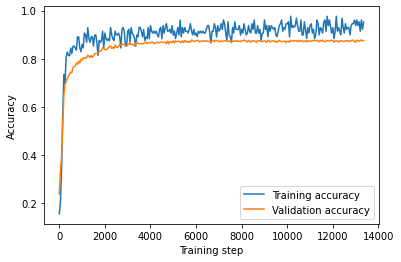

In [30]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - optimizers

PyTorch provides a number of different optimizers for us to choose from. Replace `optim.SGD` with any of `optim.RMSprop`, `optim.Adagrad` and `optim.Adam` and experiment with the number of layers and hidden units to find the best possible network.

In [31]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
layer_2 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2)

# =========
# create the optimizer
optimizer = optim.RMSprop(
    model.parameters(),
    lr=learning_rate
)
# =========

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2416.518 training accuracy: 0.078 validation accuracy: 0.066 
Step 100 loss: 2397.897 training accuracy: 0.047 validation accuracy: 0.085 
Step 150 loss: 2054.409 training accuracy: 0.101 validation accuracy: 0.104 
Step 200 loss: 2014.226 training accuracy: 0.132 validation accuracy: 0.120 
Step 250 loss: 1866.518 training accuracy: 0.148 validation accuracy: 0.142 
Step 300 loss: 1685.720 training accuracy: 0.264 validation accuracy: 0.164 
Step 350 loss: 1785.122 training accuracy: 0.194 validation accuracy: 0.183 
Step 400 loss: 1710.349 training accuracy: 0.203 validation accuracy: 0.201 
Step 450 loss: 1412.857 training accuracy: 0.318 validation accuracy: 0.216 
Step 500 loss: 1558.769 training accuracy: 0.273 validation accuracy: 0.232 
Step 550 loss: 1647.153 training accuracy: 0.271 validation accuracy: 0.245 
Step 600 loss: 1328.394 training accuracy: 0.349 validation accuracy: 0.260 
Step 650 loss: 1490.870 training accuracy: 0.297 validation accuracy: 0.271 


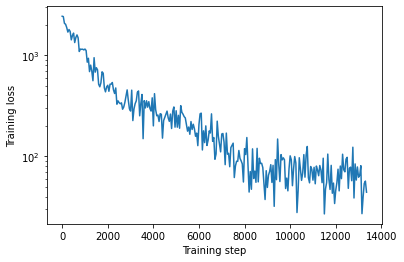

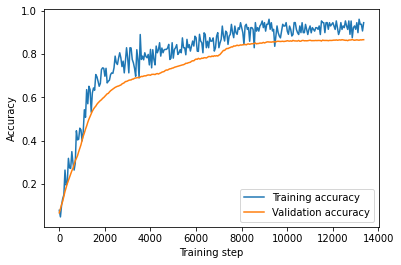

In [32]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 4 - network depth

Create a network with *two* hidden layers and compare its performance to the network with one hidden layer we just built. Try increasing the number of epochs if the loss hasn't stopped increasing.

In [43]:
# let's set some hyperparameters
batch_size = 128
# ========
# as you add an additional layer, you may wish to decrease the learning rate
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.001
n_epochs = 150
# ========
print_every = 50
num_hidden = 20

# build the neural network
layer_1 = layer(input_size, num_hidden, activation=nn.ReLU())
# ========
# Create an additional hidden layer
layer_2 = layer(num_hidden, num_hidden, activation=nn.ReLU())
# ========
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

# create the model
model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(model.parameters(),
                       lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 2638.019 training accuracy: 0.186 validation accuracy: 0.131 
Step 100 loss: 2252.909 training accuracy: 0.320 validation accuracy: 0.158 
Step 150 loss: 2284.494 training accuracy: 0.287 validation accuracy: 0.179 
Step 200 loss: 2366.671 training accuracy: 0.271 validation accuracy: 0.195 
Step 250 loss: 2130.152 training accuracy: 0.336 validation accuracy: 0.206 
Step 300 loss: 2228.850 training accuracy: 0.318 validation accuracy: 0.217 
Step 350 loss: 2137.496 training accuracy: 0.326 validation accuracy: 0.222 
Step 400 loss: 1935.178 training accuracy: 0.422 validation accuracy: 0.225 
Step 450 loss: 1904.845 training accuracy: 0.419 validation accuracy: 0.230 
Step 500 loss: 1854.867 training accuracy: 0.398 validation accuracy: 0.236 
Step 550 loss: 2107.441 training accuracy: 0.349 validation accuracy: 0.244 
Step 600 loss: 2236.467 training accuracy: 0.279 validation accuracy: 0.253 
Step 650 loss: 1893.161 training accuracy: 0.406 validation accuracy: 0.259 


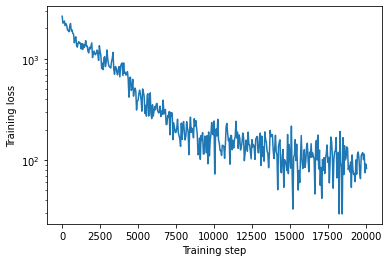

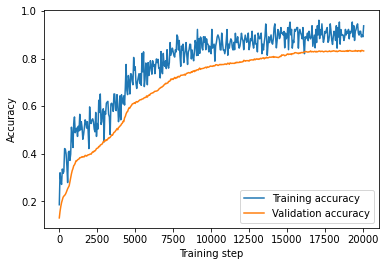

In [44]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

## Exercise 5 - activation functions

PyTorch provides a number of different activations for us to choose from. Replace `nn.ReLU` with any of `nn.Tanh`, `nn.Sigmoid` and `nn.LeakyReLU` or any others you find in the PyTorch docs to build the best possible network.

In [39]:
batch_size = 128
learning_rate = 0.001
n_epochs = 100
print_every = 50
num_hidden = 20

# ======
# build the neural network with your choice of activation function
layer_1 = layer(
    input_size, num_hidden,
    activation= nn.Tanh()
)
layer_2 = layer(
    num_hidden, num_hidden, 
    activation=nn.Tanh()
)
# ======
layer_3 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate
)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 1296.348 training accuracy: 0.008 validation accuracy: 0.039 
Step 100 loss: 1211.261 training accuracy: 0.047 validation accuracy: 0.048 
Step 150 loss: 1044.023 training accuracy: 0.070 validation accuracy: 0.060 
Step 200 loss: 986.425 training accuracy: 0.070 validation accuracy: 0.073 
Step 250 loss: 927.885 training accuracy: 0.141 validation accuracy: 0.089 
Step 300 loss: 877.157 training accuracy: 0.163 validation accuracy: 0.101 
Step 350 loss: 800.009 training accuracy: 0.155 validation accuracy: 0.116 
Step 400 loss: 720.598 training accuracy: 0.227 validation accuracy: 0.135 
Step 450 loss: 597.609 training accuracy: 0.357 validation accuracy: 0.158 
Step 500 loss: 654.130 training accuracy: 0.219 validation accuracy: 0.174 
Step 550 loss: 649.270 training accuracy: 0.248 validation accuracy: 0.195 
Step 600 loss: 624.930 training accuracy: 0.233 validation accuracy: 0.216 
Step 650 loss: 517.022 training accuracy: 0.328 validation accuracy: 0.235 
Step 700 l

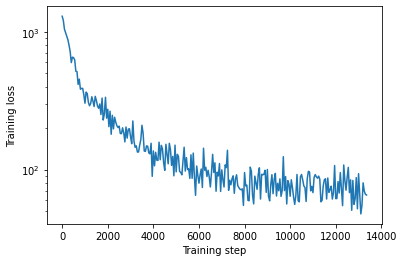

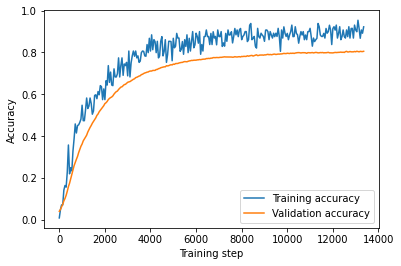

In [40]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()
# ======

## Exercise 6 - more network depth

Create a network with *five* hidden layers and compare its performance to the network with one hidden layer we just built

In [45]:
# let's set some hyperparameters
batch_size = 128
# ========
# as you add further additional layers, you may wish to decrease the learning rate, e.g. to 0.0001
# if the network hasn't finished improving after 100 epochs, you can train it for longer
learning_rate = 0.0001
n_epochs = 100
# ========
print_every = 50
num_hidden = 20

# ======
# build the neural network with five hidden layers
layer_1 = layer(
    input_size, num_hidden,
    activation=nn.Sigmoid()
)
layer_2 = layer(
    num_hidden, num_hidden, 
    activation=nn.Sigmoid()
)
layer_3 = layer(
    num_hidden,num_hidden, 
    activation=nn.Sigmoid()
)
layer_4 = layer(
    num_hidden,num_hidden, 
    activation=nn.Sigmoid()
)
layer_5 = layer(
    num_hidden,num_hidden, 
    activation=nn.Sigmoid()
)
# ======

layer_6 = layer(num_hidden, num_classes, activation=nn.Softmax(dim=-1))

model = nn.Sequential(layer_1, layer_2, layer_3, layer_4, layer_5, layer_6)

# create the optimizer
optimizer = optim.Adam(
    model.parameters(),
    lr=learning_rate)

# train the network
step = 0
results = {
    'train_loss': [],
    'train_acc': [],
    'val_acc': [],
}
for epoch in range(n_epochs):
    # randomize the order in which we see the data in each epoch
    random_order_indices = np.random.choice(train_tensor.shape[0], train_tensor.shape[0], replace=False)
    
    # iterate through the data in batches of size `batch_size`
    for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
      
        train_data_batch = train_tensor[batch_indices]
        train_labels_batch = train_labels[batch_indices]
        train_onehot = to_one_hot(train_labels_batch, num_classes)

        step += 1

        # get pass batch through layers
        output = model(train_data_batch)

        # compute cross entropy
        loss = train_onehot * torch.log(output+ 1e-6) + (1 - train_onehot) * torch.log(1 - output + 1e-6)
        loss = -1 * loss.sum()

        # backpropagate the loss
        loss.backward()

        # update parameters
        optimizer.step()

        # reset gradients
        optimizer.zero_grad()

        # evaluate accuracy on both the training and validation datasets
        if step % print_every == 0:
            
            # don't track gradients
            with torch.no_grad():
                # compute the predicted outputs
                train_prediction = output.argmax(1).numpy()

                # compute the accuracy over the batch
                acc_training = np.mean(train_prediction == train_labels_batch.numpy())

                # compute the loss on all the validation data
                loss_np = []
                output_np = []
                labels_np = []

                random_order_indices = np.random.choice(valid_tensor.shape[0], valid_tensor.shape[0], replace=False)

                for batch_indices in np.array_split(random_order_indices, random_order_indices.shape[0] // batch_size):
                    valid_data_batch = valid_tensor[batch_indices]
                    valid_labels_batch = valid_labels[batch_indices]

                    # pass through layers
                    valid_output = model(valid_data_batch)

                    # compute the predicted outputs

                    prediction_np = valid_output.argmax(1).numpy()

                    output_np.append(prediction_np.reshape(-1))
                    labels_np.append(valid_labels_batch.numpy().reshape(-1))

                    
                # compute the accuracy over the whole dataset
                output_np = np.concatenate(output_np)
                labels_np = np.concatenate(labels_np)
                acc_validation = np.mean(output_np == labels_np)

                results['train_loss'].append(loss.item())
                results['train_acc'].append(acc_training)
                results['val_acc'].append(acc_validation)
                print('Step {} loss: {:.3f} training accuracy: {:.3f} validation accuracy: {:.3f} '.format(
                    step, loss.item(), acc_training, acc_validation))

Step 50 loss: 1292.326 training accuracy: 0.000 validation accuracy: 0.001 
Step 100 loss: 1222.579 training accuracy: 0.000 validation accuracy: 0.001 
Step 150 loss: 1203.947 training accuracy: 0.000 validation accuracy: 0.001 
Step 200 loss: 1215.938 training accuracy: 0.000 validation accuracy: 0.001 
Step 250 loss: 1137.353 training accuracy: 0.000 validation accuracy: 0.001 
Step 300 loss: 1112.924 training accuracy: 0.000 validation accuracy: 0.001 
Step 350 loss: 1092.297 training accuracy: 0.000 validation accuracy: 0.001 
Step 400 loss: 1038.859 training accuracy: 0.000 validation accuracy: 0.001 
Step 450 loss: 1035.800 training accuracy: 0.000 validation accuracy: 0.001 
Step 500 loss: 995.615 training accuracy: 0.000 validation accuracy: 0.001 
Step 550 loss: 1025.000 training accuracy: 0.000 validation accuracy: 0.001 
Step 600 loss: 976.822 training accuracy: 0.000 validation accuracy: 0.001 
Step 650 loss: 947.862 training accuracy: 0.000 validation accuracy: 0.001 
Ste

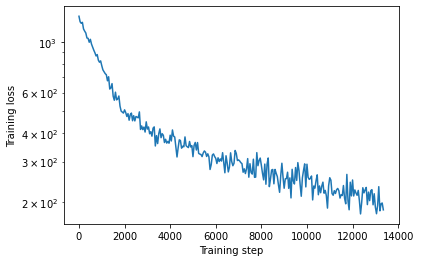

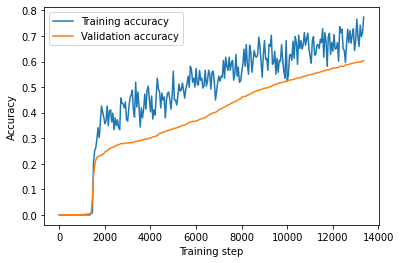

In [46]:
plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_loss'])
plt.xlabel('Training step')
plt.ylabel('Training loss')
plt.yscale('log')

plt.figure()
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['train_acc'], label='Training accuracy')
plt.plot(np.arange(len(results['train_loss'])) * print_every, results['val_acc'], label='Validation accuracy')
plt.xlabel('Training step')
plt.ylabel('Accuracy')
plt.legend()

### Discussion

1. How did the more complex networks you built compare to the simple network we started with?
2. Which was more useful -- adding _depth_ to your network or adding width?
3. Which optimizer performed best?
4. What had the biggest effect on performance: depth, width, or optimizer?

#### Re-Cap
1. Power of PyTorch is to allow us to setup the neural networks using nn.Module

2. We can use the same neural network over and over with different data without having to re-write the code.